# Alternative Epidemiological Parameters & Speed Testing

In [32]:
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

import pickle
import copy

from epimodel.preprocessing.data_preprocessor import preprocess_data
from epimodel import EpidemiologicalParameters, DefaultModel
from epimodel.pymc3_models.base_model import add_cms_to_plot, produce_CIs

import scipy.stats as stats

%matplotlib inline

In [121]:
exp_labels = [
    'Legacy',
    'Legacy - New GI',
    'Legacy - New GI+Reporting',
    'Legacy - New GI+Reporting+Death',
    'Default - Old GI',
    'Default - Old GI+Deaths',
    'Default - Old GI+Deaths+Reporting',
    'Default - Fixed Dispersion\nOld GI+Deaths+Reporting',
    'Default - Lognorm Output\nOld GI+Deaths+Reporting',
    'Legacy - Fixed Dispersion',
    'Legacy - Lognorm output',
    'Legacy - New Seeding',
    'Legacy - No Smoothing',
    'Legacy - one schools feature',
    'Legacy - efficient growth noise',
    'Default',
    'Default - poisson',
    'Default - poisson reparam',
    'Default - reparam',
    'Default - fixed disp 5, no smoothing',
    'Default - learnt disp, no smoothing',
    'Default - learnt 3 day smoothing',
    'Default - learnt 5 day smoothing',
]

# Changes in Epidemiological Parameters

In [122]:
GI_MEAN_OLD = 6.67
GI_SD_OLD = 2.37

DelayProbCases = np.array([0., 0.0252817, 0.03717965, 0.05181224, 0.06274125,
                           0.06961334, 0.07277174, 0.07292397, 0.07077184, 0.06694868,
                           0.06209945, 0.05659917, 0.0508999, 0.0452042, 0.03976573,
                           0.03470891, 0.0299895, 0.02577721, 0.02199923, 0.01871723,
                           0.01577148, 0.01326564, 0.01110783, 0.00928827, 0.0077231,
                           0.00641162, 0.00530572, 0.00437895, 0.00358801, 0.00295791,
                           0.0024217, 0.00197484])

DelayProbDeaths = np.array([0.00000000e+00, 2.24600347e-06, 3.90382088e-05, 2.34307085e-04,
                            7.83555003e-04, 1.91221622e-03, 3.78718437e-03, 6.45923913e-03,
                            9.94265709e-03, 1.40610714e-02, 1.86527920e-02, 2.34311421e-02,
                            2.81965055e-02, 3.27668001e-02, 3.68031574e-02, 4.03026198e-02,
                            4.30521951e-02, 4.50637136e-02, 4.63315047e-02, 4.68794406e-02,
                            4.67334059e-02, 4.59561441e-02, 4.47164503e-02, 4.29327455e-02,
                            4.08614522e-02, 3.85082076e-02, 3.60294203e-02, 3.34601703e-02,
                            3.08064505e-02, 2.81766028e-02, 2.56165924e-02, 2.31354369e-02,
                            2.07837267e-02, 1.86074383e-02, 1.65505661e-02, 1.46527043e-02,
                            1.29409383e-02, 1.13695920e-02, 9.93233881e-03, 8.66063386e-03,
                            7.53805464e-03, 6.51560047e-03, 5.63512264e-03, 4.84296166e-03,
                            4.14793478e-03, 3.56267297e-03, 3.03480656e-03, 2.59406730e-03,
                            2.19519042e-03, 1.85454286e-03, 1.58333238e-03, 1.33002321e-03,
                            1.11716435e-03, 9.35360376e-04, 7.87780158e-04, 6.58601602e-04,
                            5.48147154e-04, 4.58151351e-04, 3.85878963e-04, 3.21623249e-04,
                            2.66129174e-04, 2.21364768e-04, 1.80736566e-04, 1.52350196e-04])

ep = EpidemiologicalParameters()
DelayProbCases_NEW, DelayProbDeaths_NEW = ep.generate_reporting_and_fatality_delays(with_noise=False)
GI_MEAN_NEW, GI_SD_NEW = ep.generate_gi(with_noise=False)

1.624
0.518
5.2
4.75
16.71
7.52
Raw: reporting delay mean 11.001932076911295
Raw: fatality delay mean 22.512687003646274
Generated Reporting Delay: mean: 10.830, sd: 5.359, max: 32
Generated Fatality Delay: mean: 22.278, sd: 7.760, max: 48
Generation Interval: mean: 5.060, sd: 2.075


In [123]:
def plot_gamma_pdf(mean, sd, l):
    k = mean ** 2 / sd ** 2 #shape
    theta = sd ** 2 / mean #scale
    xvals = np.linspace(0, 14, 500)
    pdf_vals = stats.gamma.pdf(xvals, a=k, scale=theta)
    plt.plot(xvals, pdf_vals, label=l)

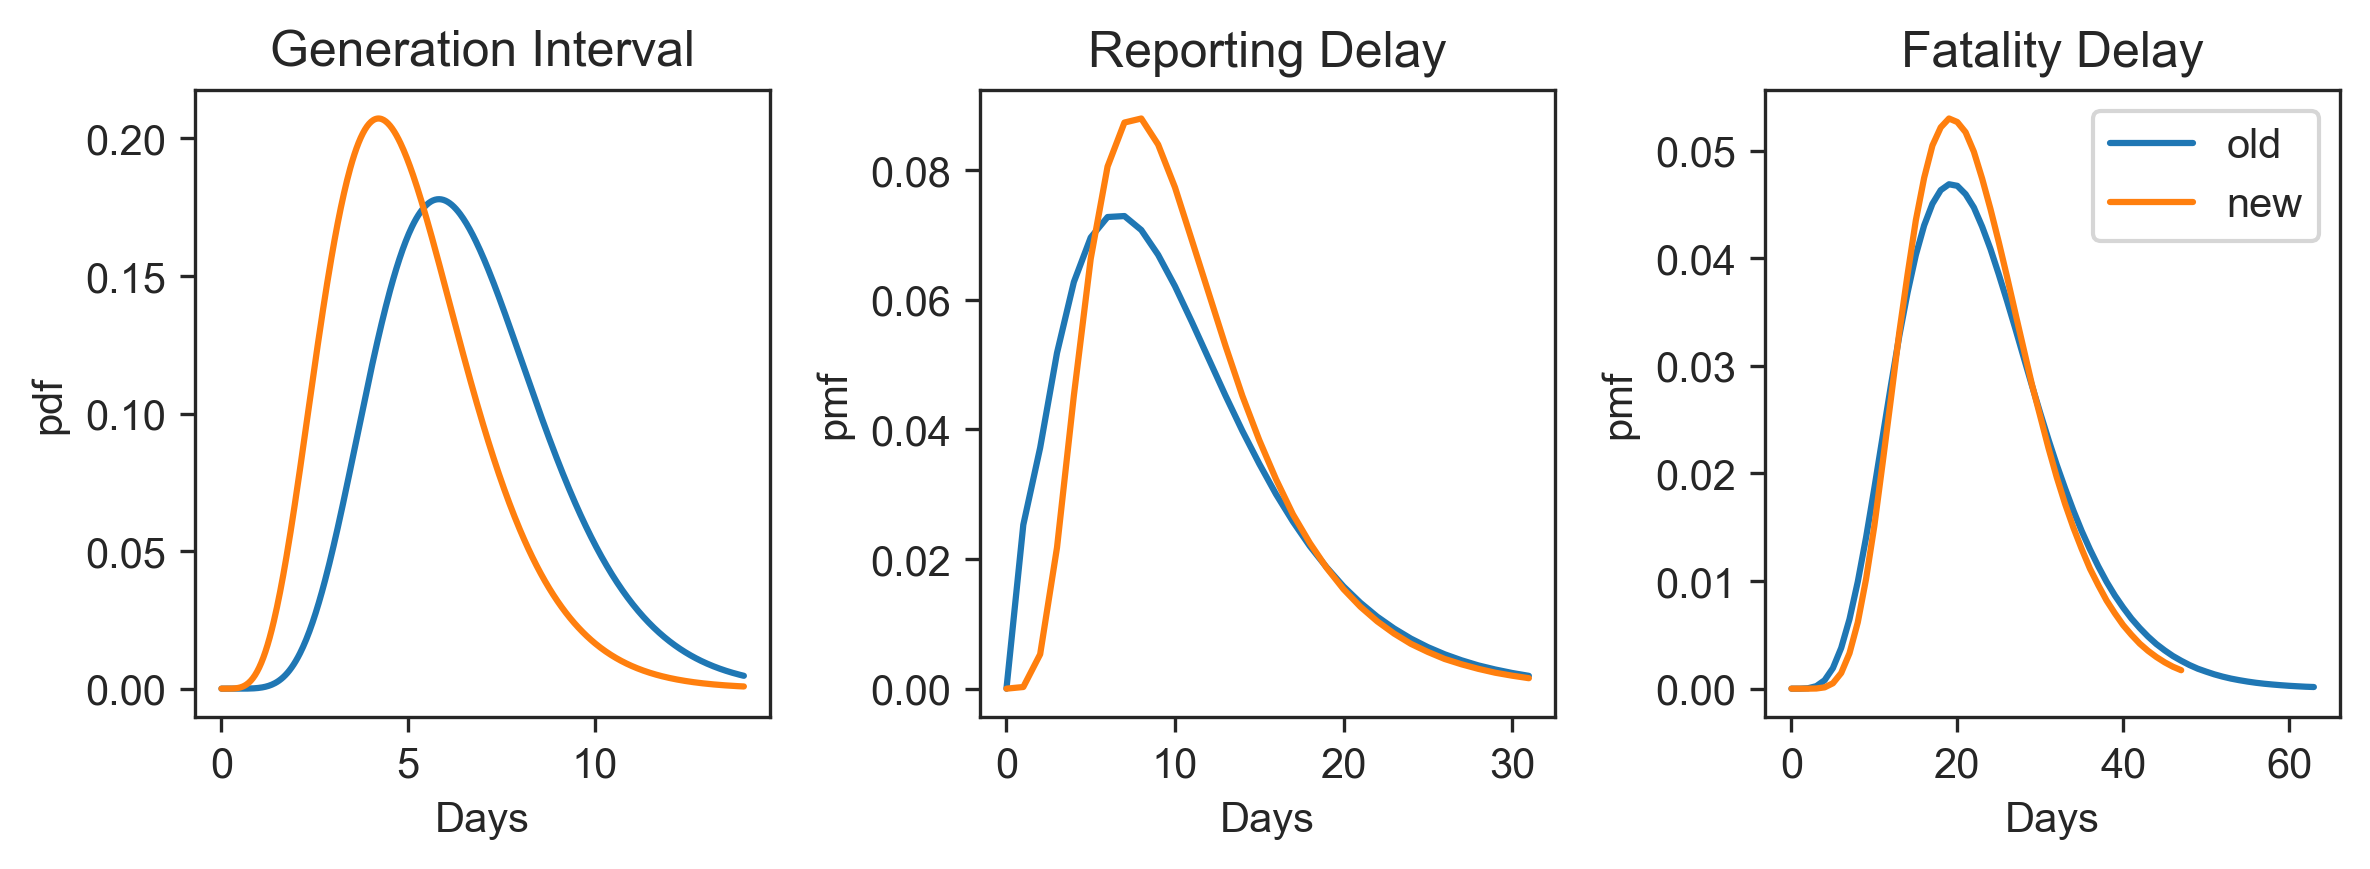

In [124]:
plt.figure(figsize=(8, 3), dpi=300)
plt.subplot(131)
plot_gamma_pdf(GI_MEAN_OLD, GI_SD_OLD, 'old')
plot_gamma_pdf(GI_MEAN_NEW, GI_SD_NEW, 'new')
plt.xlabel('Days')
plt.ylabel('pdf')
plt.title('Generation Interval')

plt.subplot(132)
plt.plot(DelayProbCases, label='old')
plt.plot(DelayProbCases_NEW.flatten(), label='new')
plt.xlabel('Days')
plt.ylabel('pmf')
plt.title('Reporting Delay')

plt.subplot(133)
plt.plot(DelayProbDeaths, label='old')
plt.plot(DelayProbDeaths_NEW.flatten(), label='new')
plt.xlabel('Days')
plt.ylabel('pmf')
plt.title('Fatality Delay')
plt.legend()
plt.tight_layout()

# Brief Results Summary

In [128]:
def load_exp_summary(exp_num):
    path = f'../../server/aws_bug_exps_new/bug_exps/exp_{exp_num}.pkl'
    trace = pickle.load(open(path, 'rb'))
    
    time_elapsed = copy.deepcopy(trace.time_elapsed)/60
    cm_reduction = copy.deepcopy(trace.CMReduction)
    name = exp_labels[exp_num]
    # clear from memory
    del trace
    return name, time_elapsed, cm_reduction

In [129]:
exps = [15, 18, 19, 20, 21, 22]

In [130]:
# exps = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

names = []
times = []
cm_reds = []
for e in exps:
    name, time, cmred = load_exp_summary(e)
    names.append(name)
    times.append(time)
    cm_reds.append(cmred)

## Runtimes

Text(0.5, 1.0, 'Note: longer runtime usually associated with "troublesome" posterior geometry')

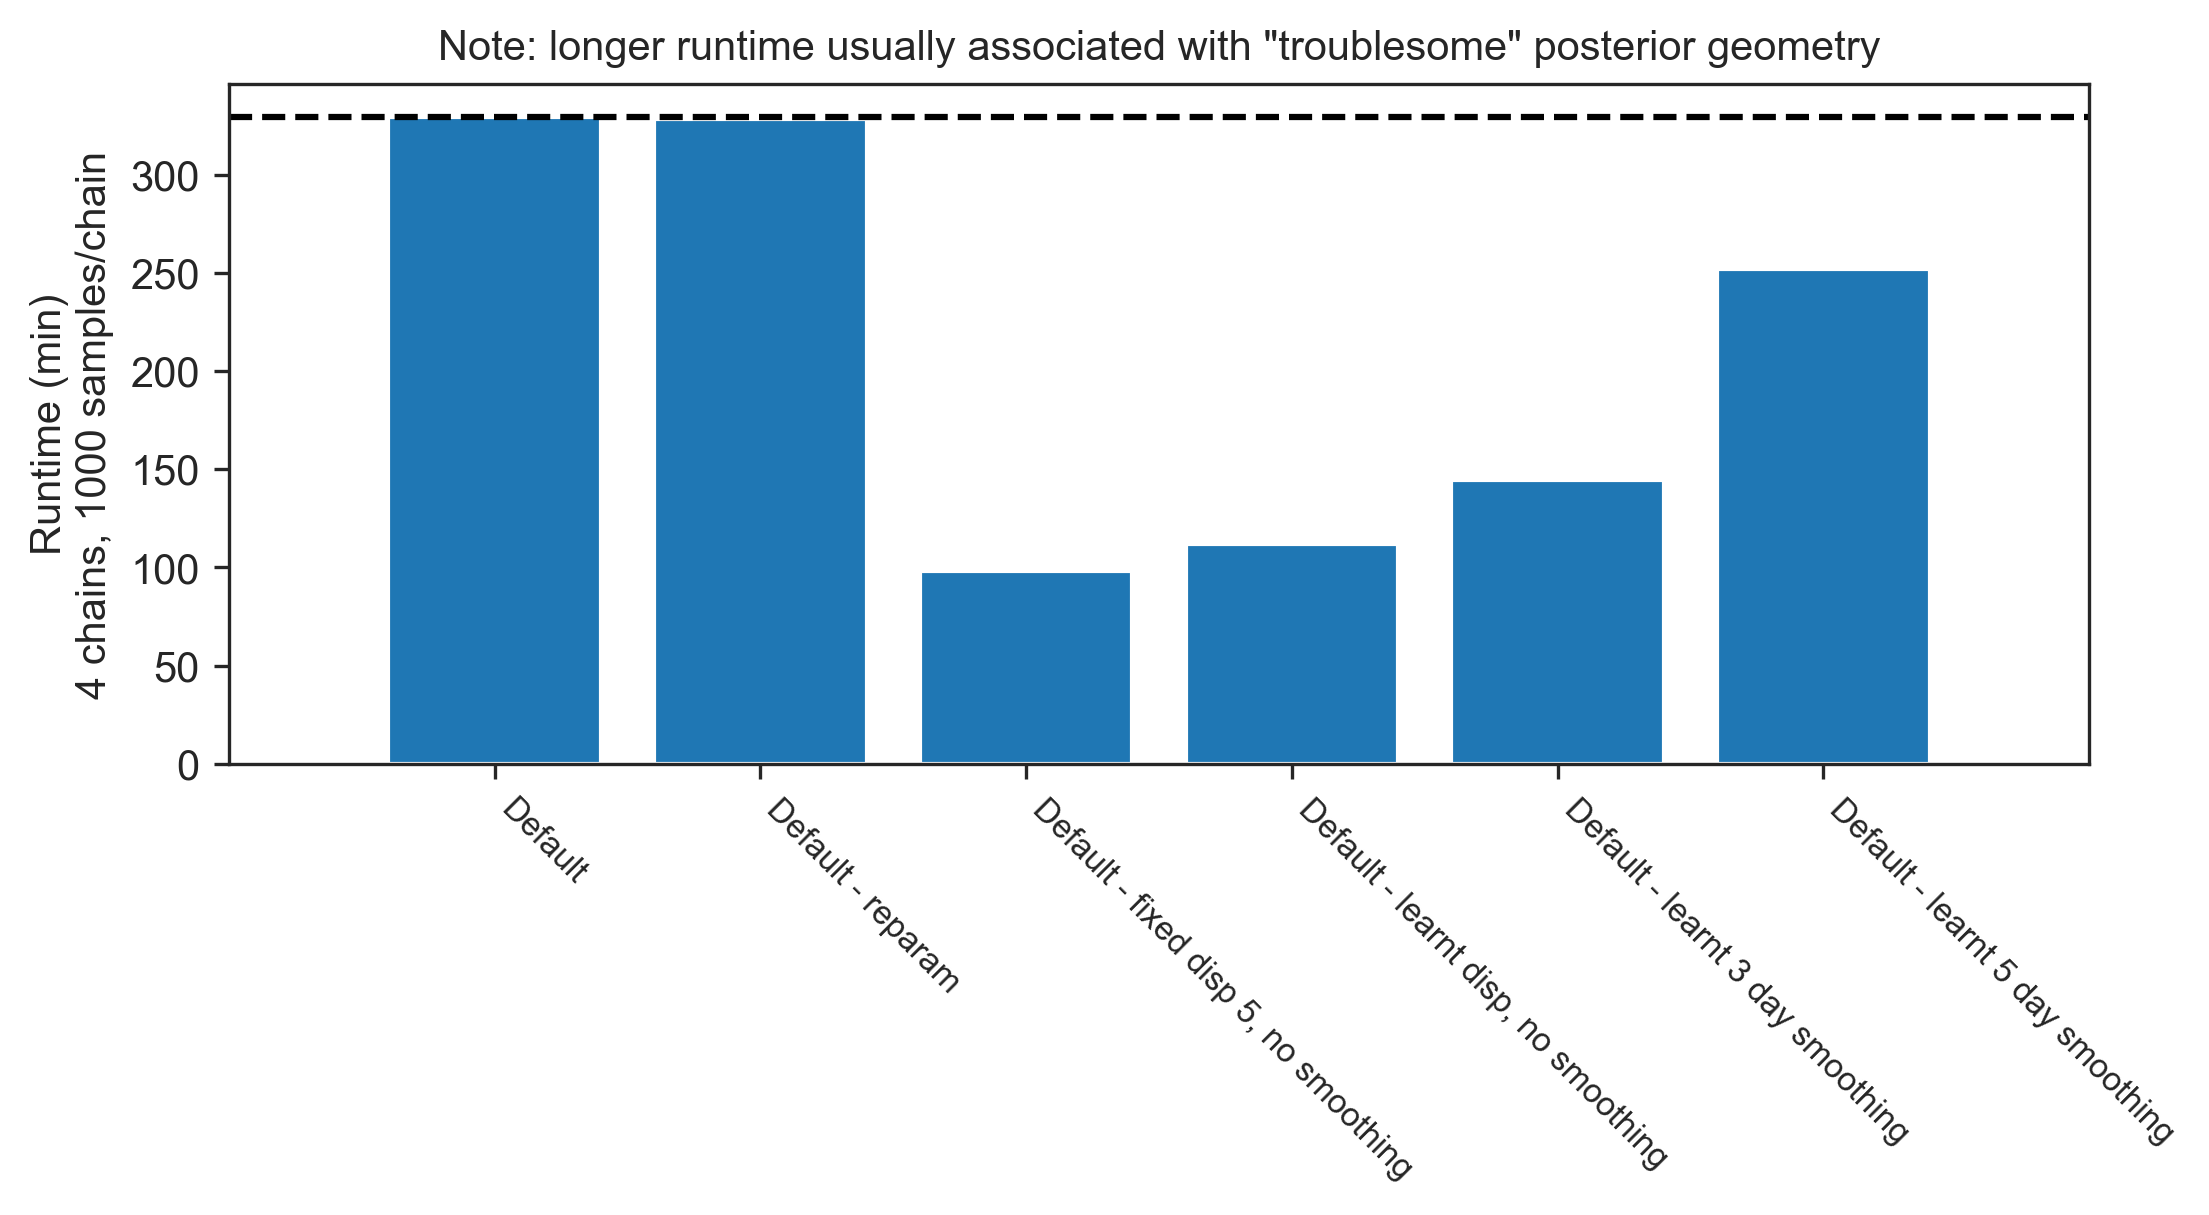

In [131]:
plt.figure(figsize=(8, 3), dpi=300)
plt.bar(np.arange(len(times)), times)
plt.ylabel('Runtime (min)\n4 chains, 1000 samples/chain')
plt.xticks(np.arange(len(times)), names, fontsize=8, ha='left', rotation=-45)
plt.plot([-1, len(times)], [times[0], times[0]], '--k')
plt.xlim([-1, len(times)])
plt.title('Note: longer runtime usually associated with "troublesome" posterior geometry', fontsize=10)

# NPI effectiveness estimates

In [132]:
derived_features_def = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [2, 1]),
 ("Gatherings limited to 10\npeople or less", [3, 2, 1]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [4, 5]),
 ("Schools and universities closed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),
 ]

derived_features_comb = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [2, 1]),
 ("Gatherings limited to 10\npeople or less", [3, 2, 1]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [4, 5]),
 ("Schools and universities closed", [6]),
 ("Stay-at-home order\n(with exemptions)", [7]),
 ]


cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, width, size=8, zeros=None, comb=False):
    if comb:
        derived_features = derived_features_comb
    else:
        derived_features = derived_features_def
        
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    if zeros is not None:
        for z in zeros:
            if z < nF:
                res[:, z] = 1e5
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        if cm > 7:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25*0.25, linewidth=width, linestyle="--")
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75*0.25, linewidth=width, linestyle="--")
        else:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
def setup_large_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 8*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
        
def setup_larger_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 9*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=12, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
    
def setup_small_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features_def)
    ax = plt.gca()
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, 0, 50, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 13*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)

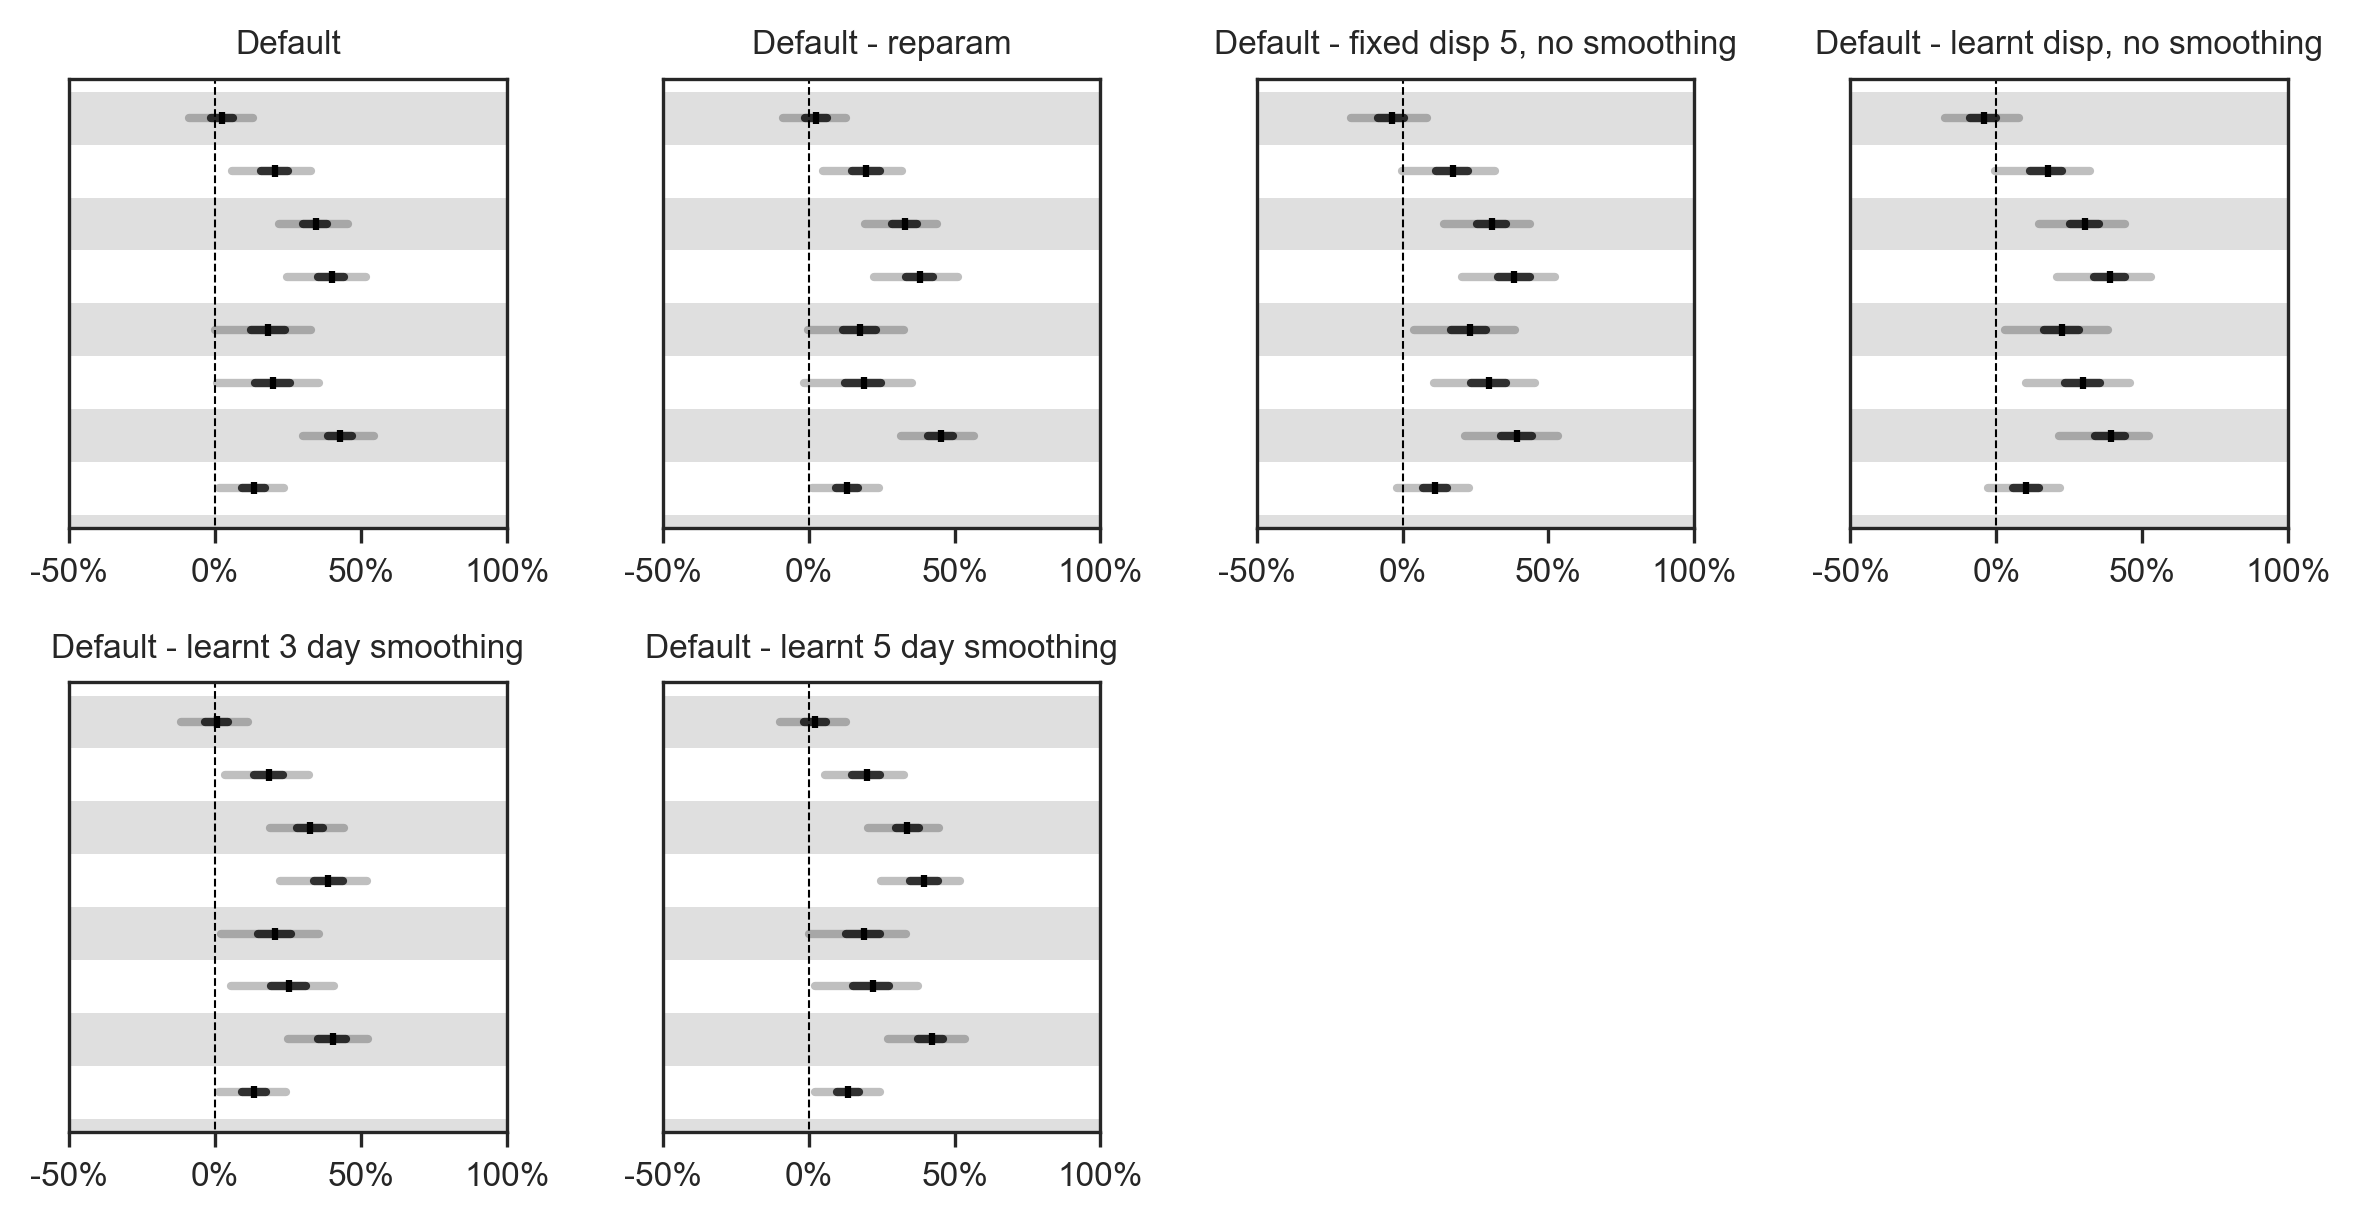

In [133]:
plt.figure(figsize=(8, 8), dpi=300)
for i, (name, cmred) in enumerate(zip(names, cm_reds)):
    plt.subplot(4, 4, i+1)
    setup_small_plot(False, False, False)
    comb = name == 'Legacy - one schools feature'
    add_trace_to_plot(cmred, 0, 'k', '', 1, 2, comb=comb)
    plt.title(name, fontsize=8)
plt.tight_layout()

# NPI Correlation Plot

In [134]:
def corr_plot(trace):
    corr = np.corrcoef(trace, rowvar=False)
    plt.imshow(corr, vmin=-1, vmax=1, cmap='magma')
    
    plt.yticks(np.arange(0, 9))
    plt.xticks(np.arange(0, 9))

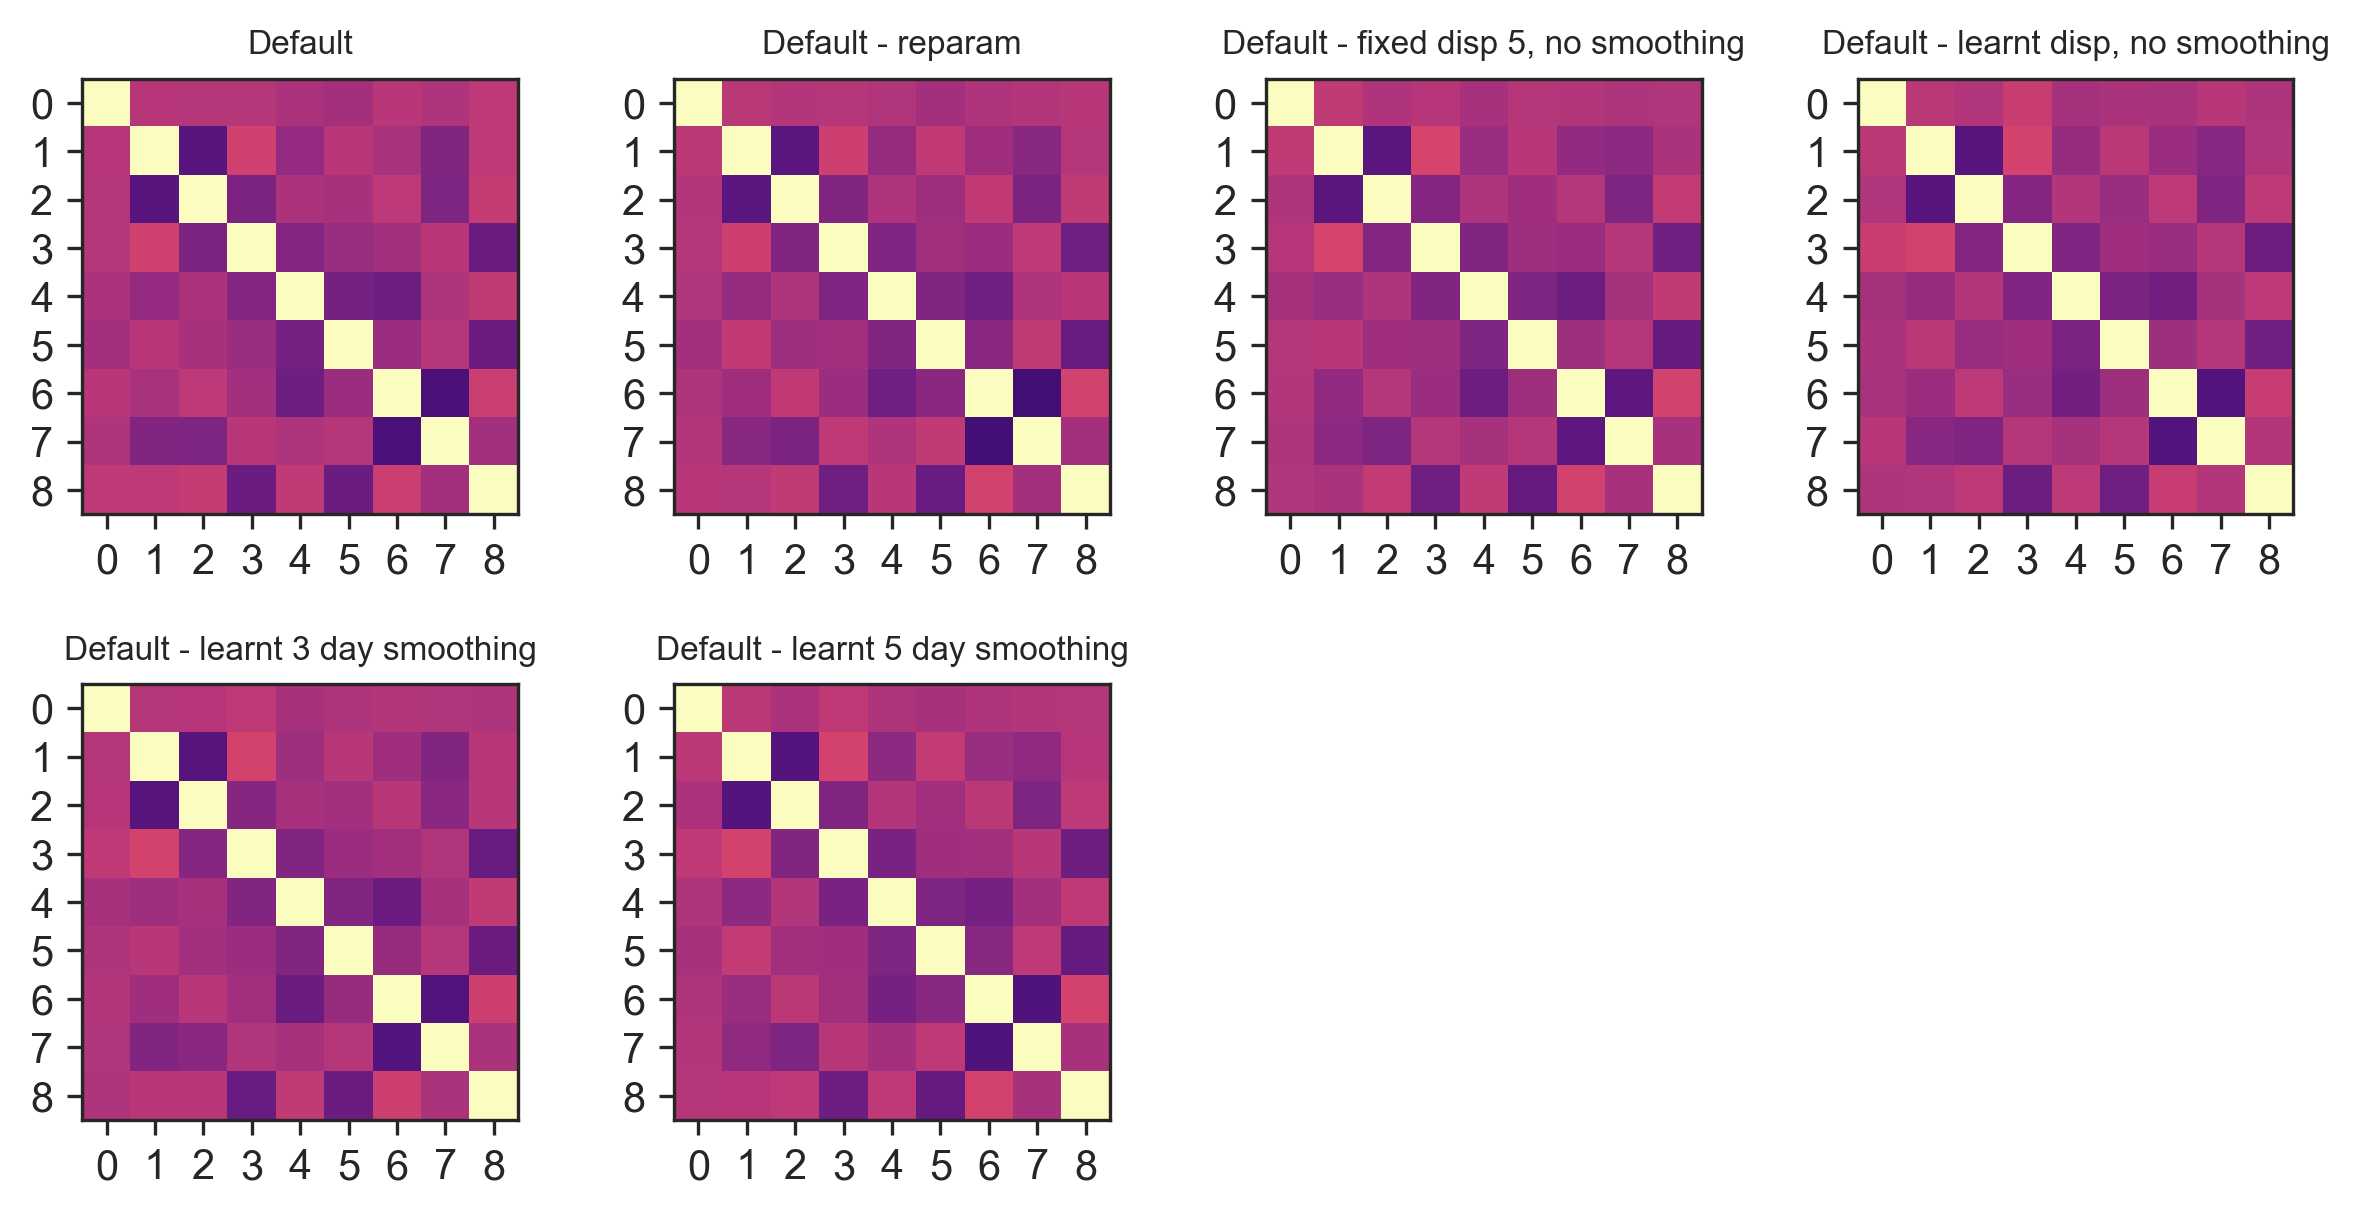

In [135]:
plt.figure(figsize=(8, 8), dpi=300)
for i, (name, cmred) in enumerate(zip(names, cm_reds)):
    plt.subplot(4, 4, i+1)
    corr_plot(cmred)
    plt.title(name, fontsize=8)
plt.tight_layout()

# let's see how the traces are

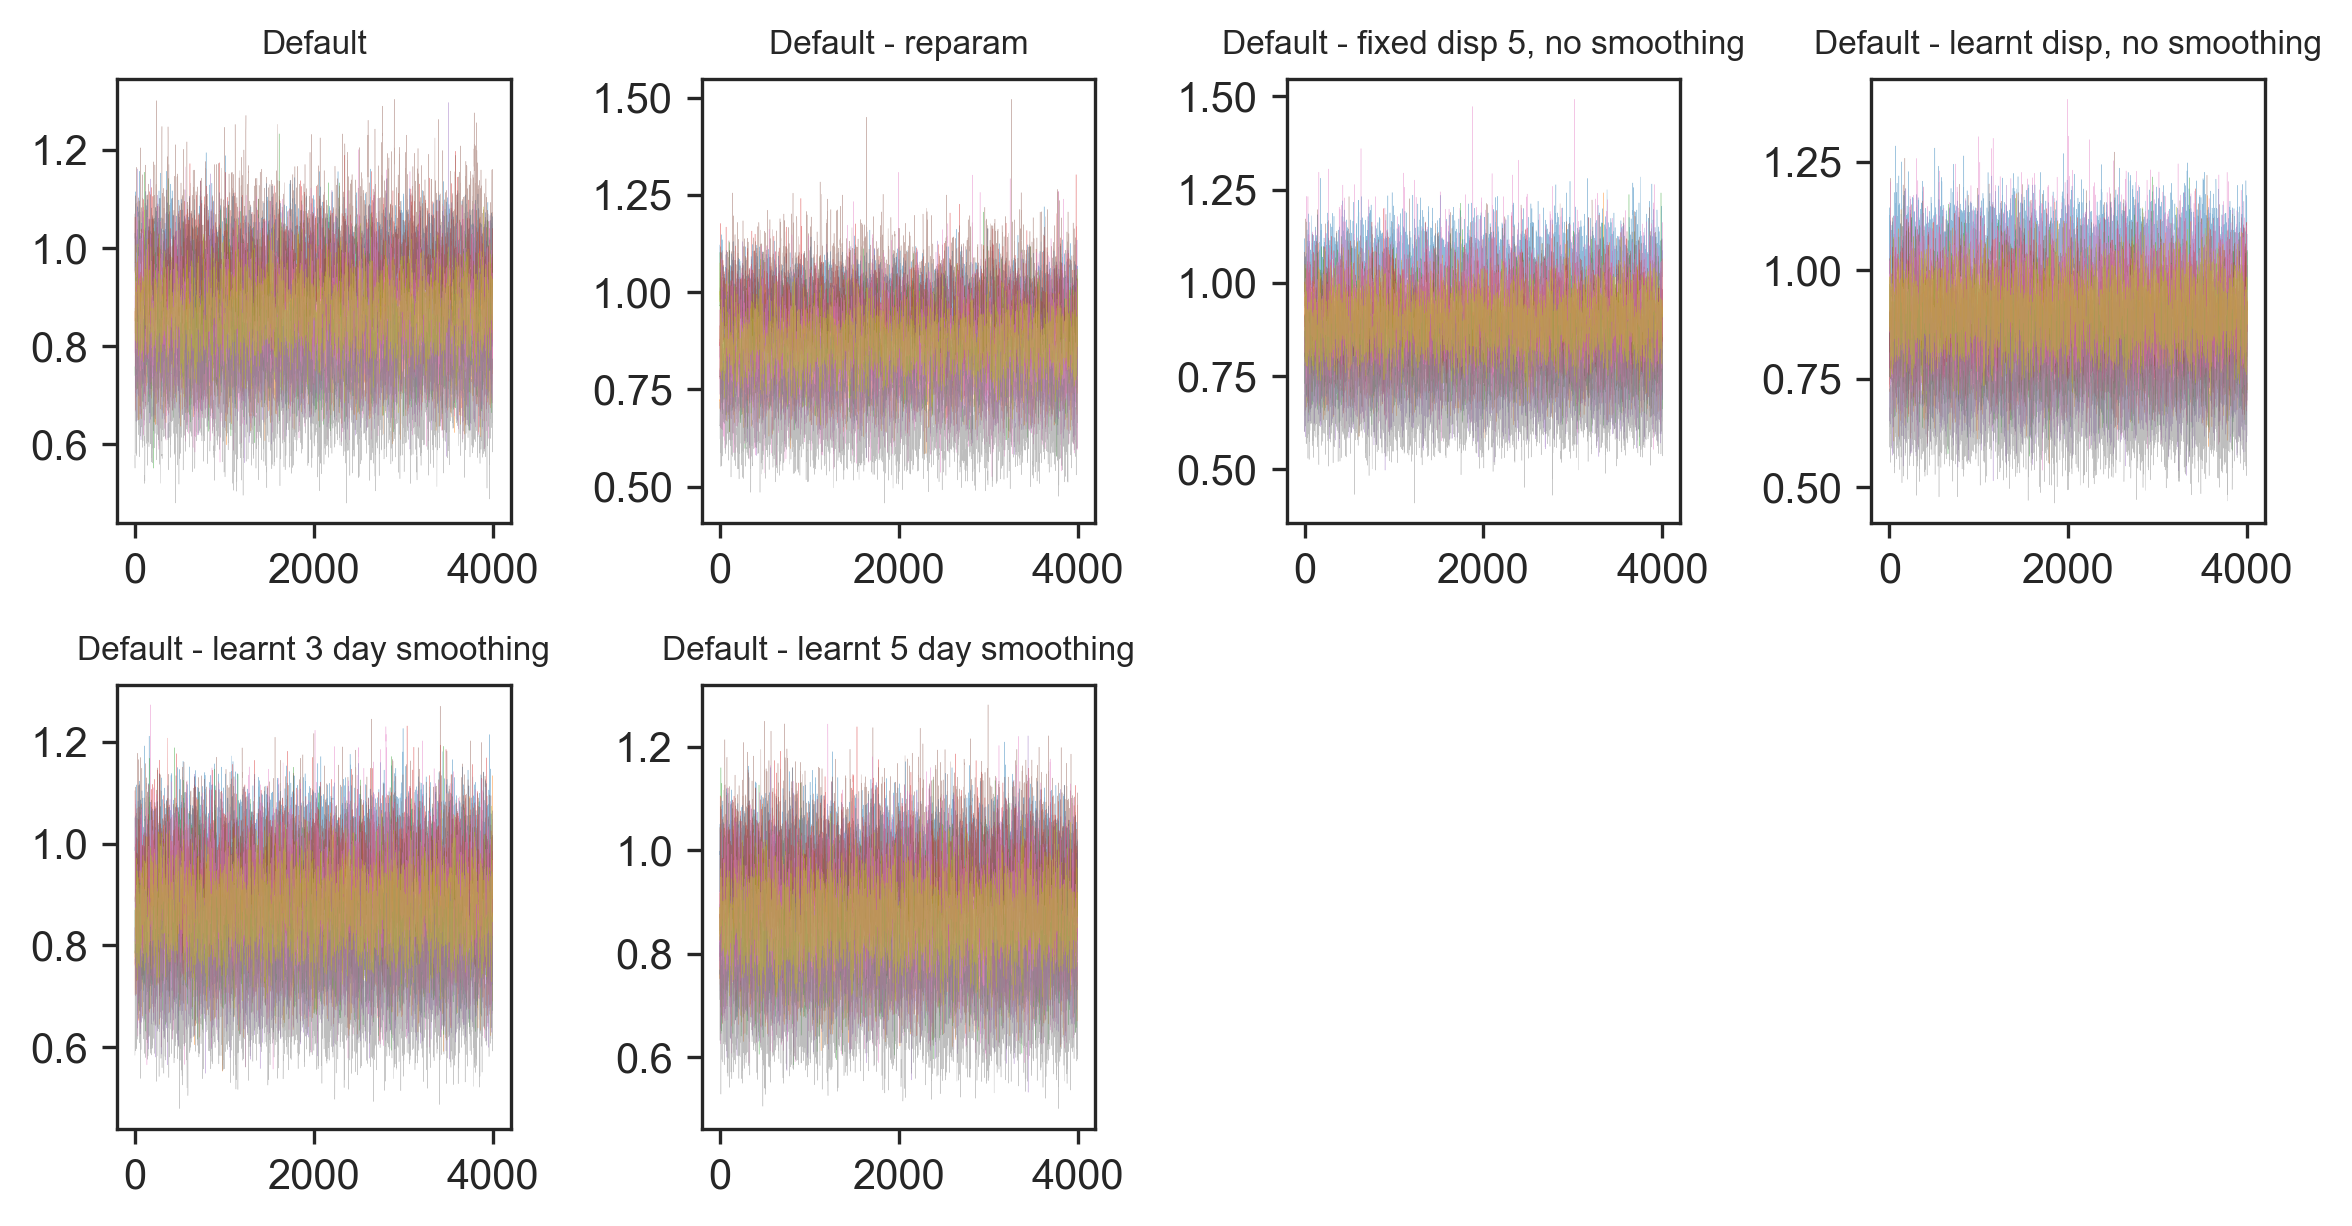

In [136]:
plt.figure(figsize=(8, 8), dpi=300)
for i, (name, cmred) in enumerate(zip(names, cm_reds)):
    plt.subplot(4, 4, i+1)
    plt.plot(cmred, linewidth=0.1, alpha=0.5)
    comb = name == 'Legacy - one schools feature'
    plt.title(name, fontsize=8)
plt.tight_layout()

# Look at dispersion

In [145]:
def load_dispersion_summary(exp_num):
    path = f'../../server/aws_bug_exps_new/bug_exps/exp_{exp_num}.pkl'
    trace = pickle.load(open(path, 'rb'))
    name = exp_labels[exp_num]
        
    if 'Dispersion' in trace.varnames:
        disp = copy.deepcopy(trace.Dispersion)
    elif 'Phi' in trace.varnames:
        disp = copy.deepcopy(trace.Phi)
    elif 'Phi_1' in trace.varnames:
        disp = copy.deepcopy(trace.Phi_1)
    else:
        disp = None
    
    del trace
    return name, disp

In [146]:
names = []
dispersions = []
for e in exps:
    name, dis = load_dispersion_summary(e)
    names.append(name)
    dispersions.append(dis)

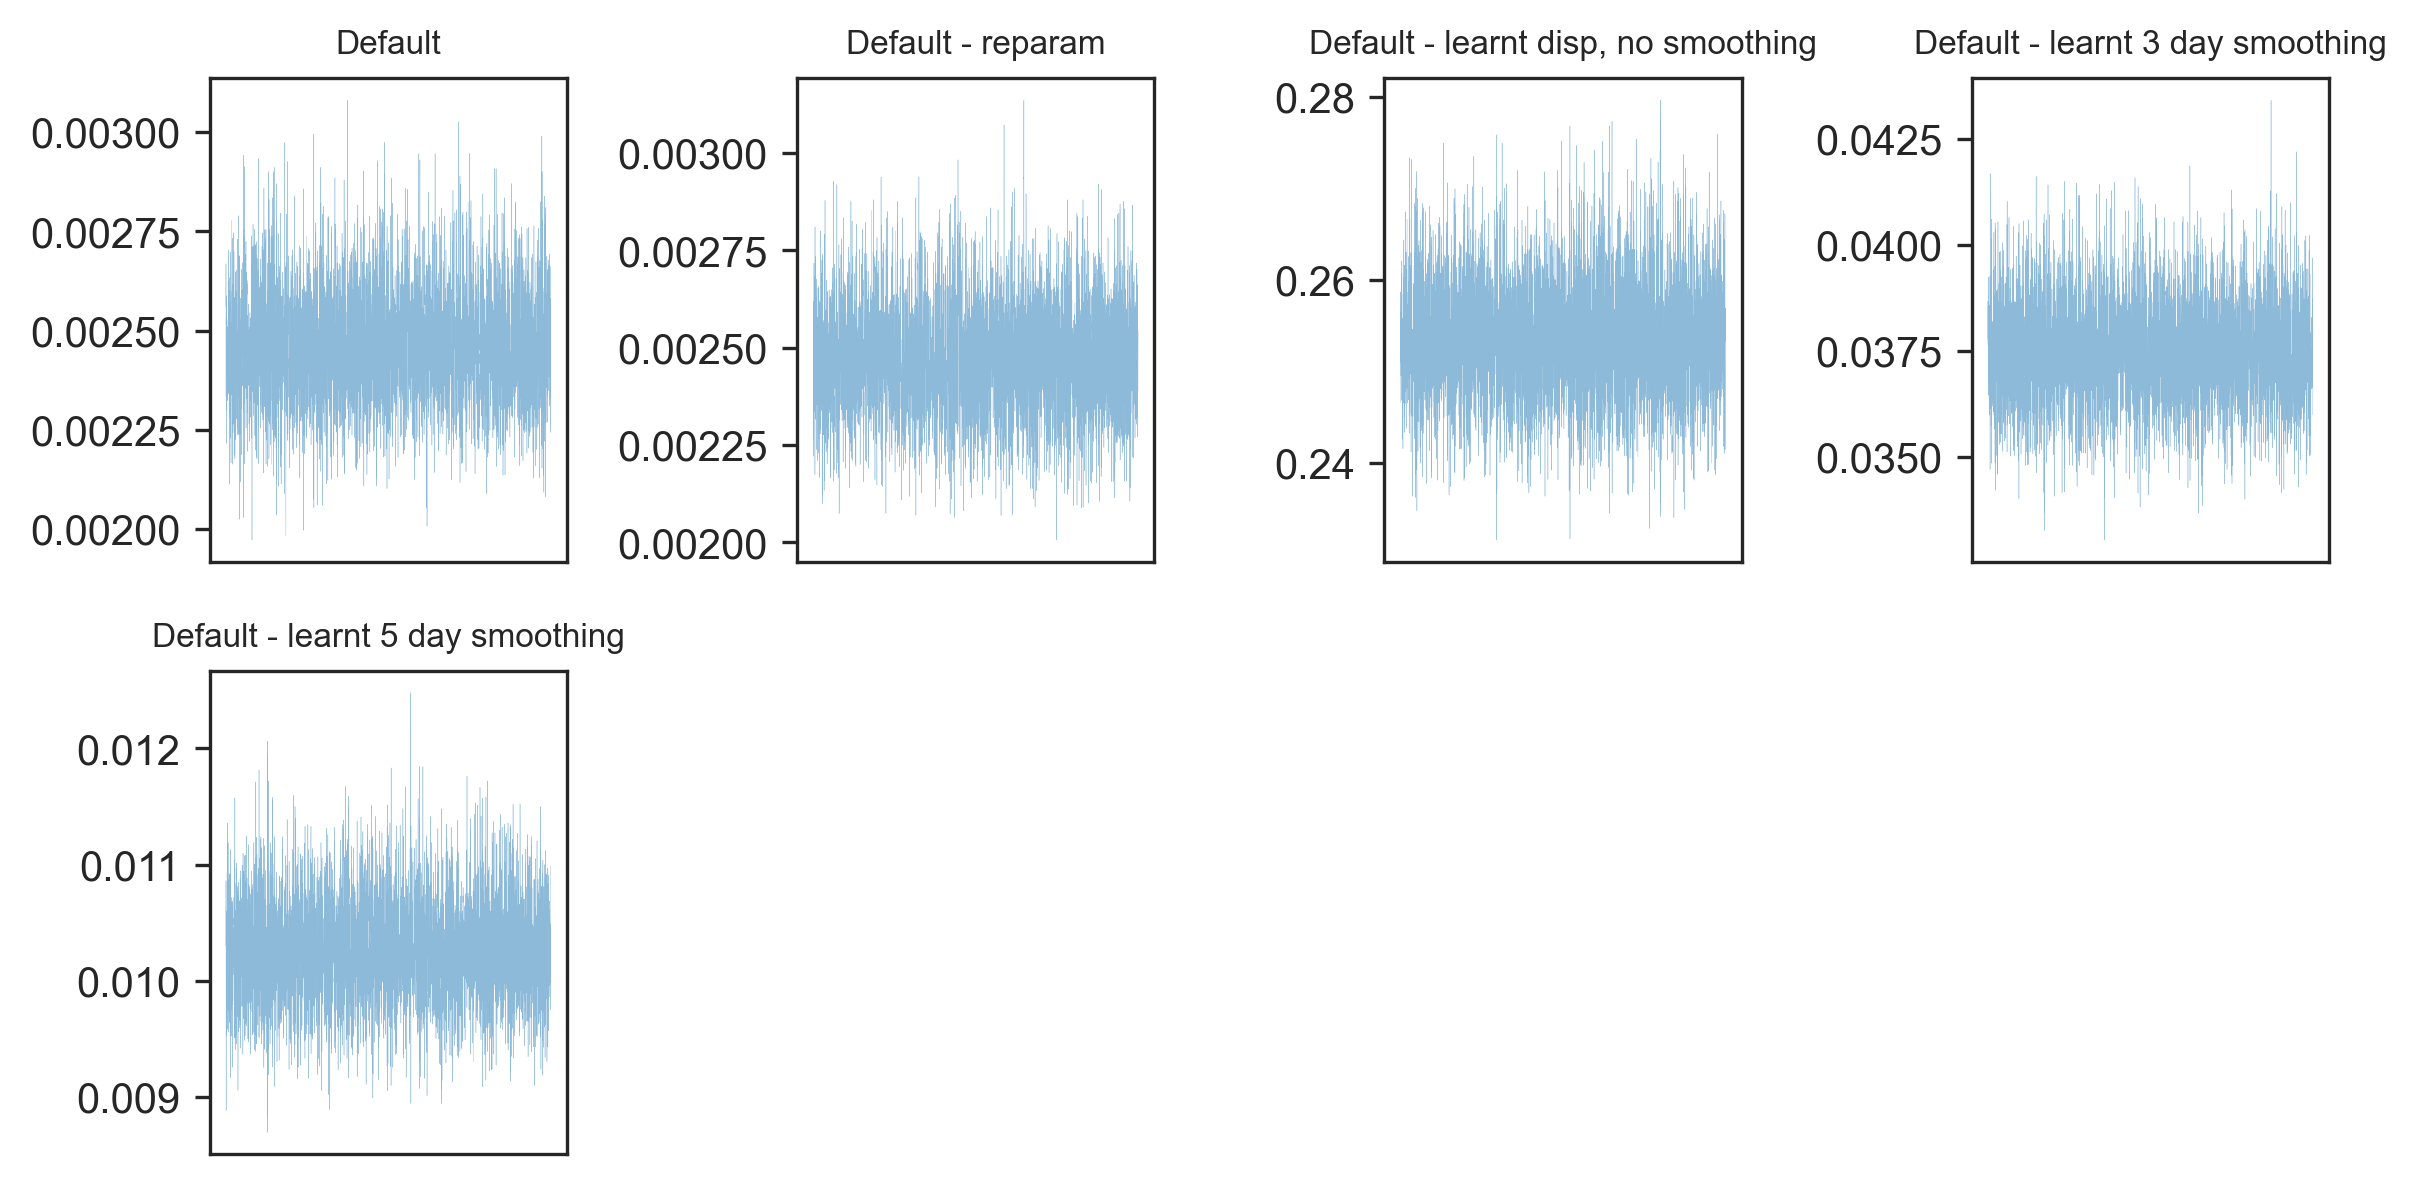

In [147]:
plt.figure(figsize=(8, 8), dpi=300)
count = 1
for i, (name, disp) in enumerate(zip(names, dispersions)):
    if disp is not None:
        plt.subplot(4, 4, count)
        plt.plot(disp, linewidth=0.1, alpha=0.5)
        plt.title(name, fontsize=8)
        count += 1
        plt.xticks([])
plt.tight_layout()

# Predictive Posterior

In [17]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30')
data.mask_reopenings()

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Smoothing
Note: did not smooth deaths in Albania
Note: did not smooth deaths in Georgia
Note: did not smooth deaths in Iceland
Note: did not smooth deaths in Latvia
Note: did not smooth deaths in New Zealand
Note: did not smooth deaths in Singapore
Note: did not smooth deaths in Slovakia
Masking invalid values
Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ 

In [25]:
data_ns = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing = 1)
data_ns.mask_reopenings()

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values
Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Maskin

In [18]:
data.Rs[40]

'GB'

In [19]:
def load_rg_summary(exp_num, rg_id = 40):
    path = f'../../server/bug_exps_new/bug_exps/exp_{exp_num}.pkl'
    trace = pickle.load(open(path, 'rb'))
    name = exp_labels[exp_num]
    
    # for predictive dist just use 60
    if 'Dispersion' in trace.varnames and 'Fixed Dispersion' not in name:
        alpha = np.mean(1/trace.Dispersion)
    elif 'Phi' in trace.varnames and 'Fixed Dispersion' not in name:
        alpha = np.mean(trace.Phi)
    elif 'Phi_1' in trace.varnames and 'Fixed Dispersion' not in name:
        alpha = np.mean(trace.Phi_1)
    else:
        alpha = 60
    
    ec = copy.deepcopy(trace.ExpectedCases[:, 40, :])
    ed = copy.deepcopy(trace.ExpectedDeaths[:, 40, :])
    
    del trace
    
    return ec, ed, alpha, name

In [102]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

def epicurve_plot(data, r_i, eco, ed, alpha, start_d_i = 30):
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
    else:
        end_d_i = len(data.Ds)

    nS, nDs = ec.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=ed, alpha=alpha)
        ed_output = dist.random()
    except ValueError:
        ed_output = 0 * ed
        means_d = means_d * 0
        lu_id = lu_id * 0
        up_id = up_id * 0

    means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
        ed_output
    )

    nS, nDs = eco.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=eco, alpha=alpha)
        eco_output = dist.random()
    except ValueError:
        eco_output = 10**-10 * ec

    means_expected_cases, lu_ec, up_ec, _, _ = produce_CIs(
        eco_output
    )

    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()
    
    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths (Smoothed)",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases (Smoothed)",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)

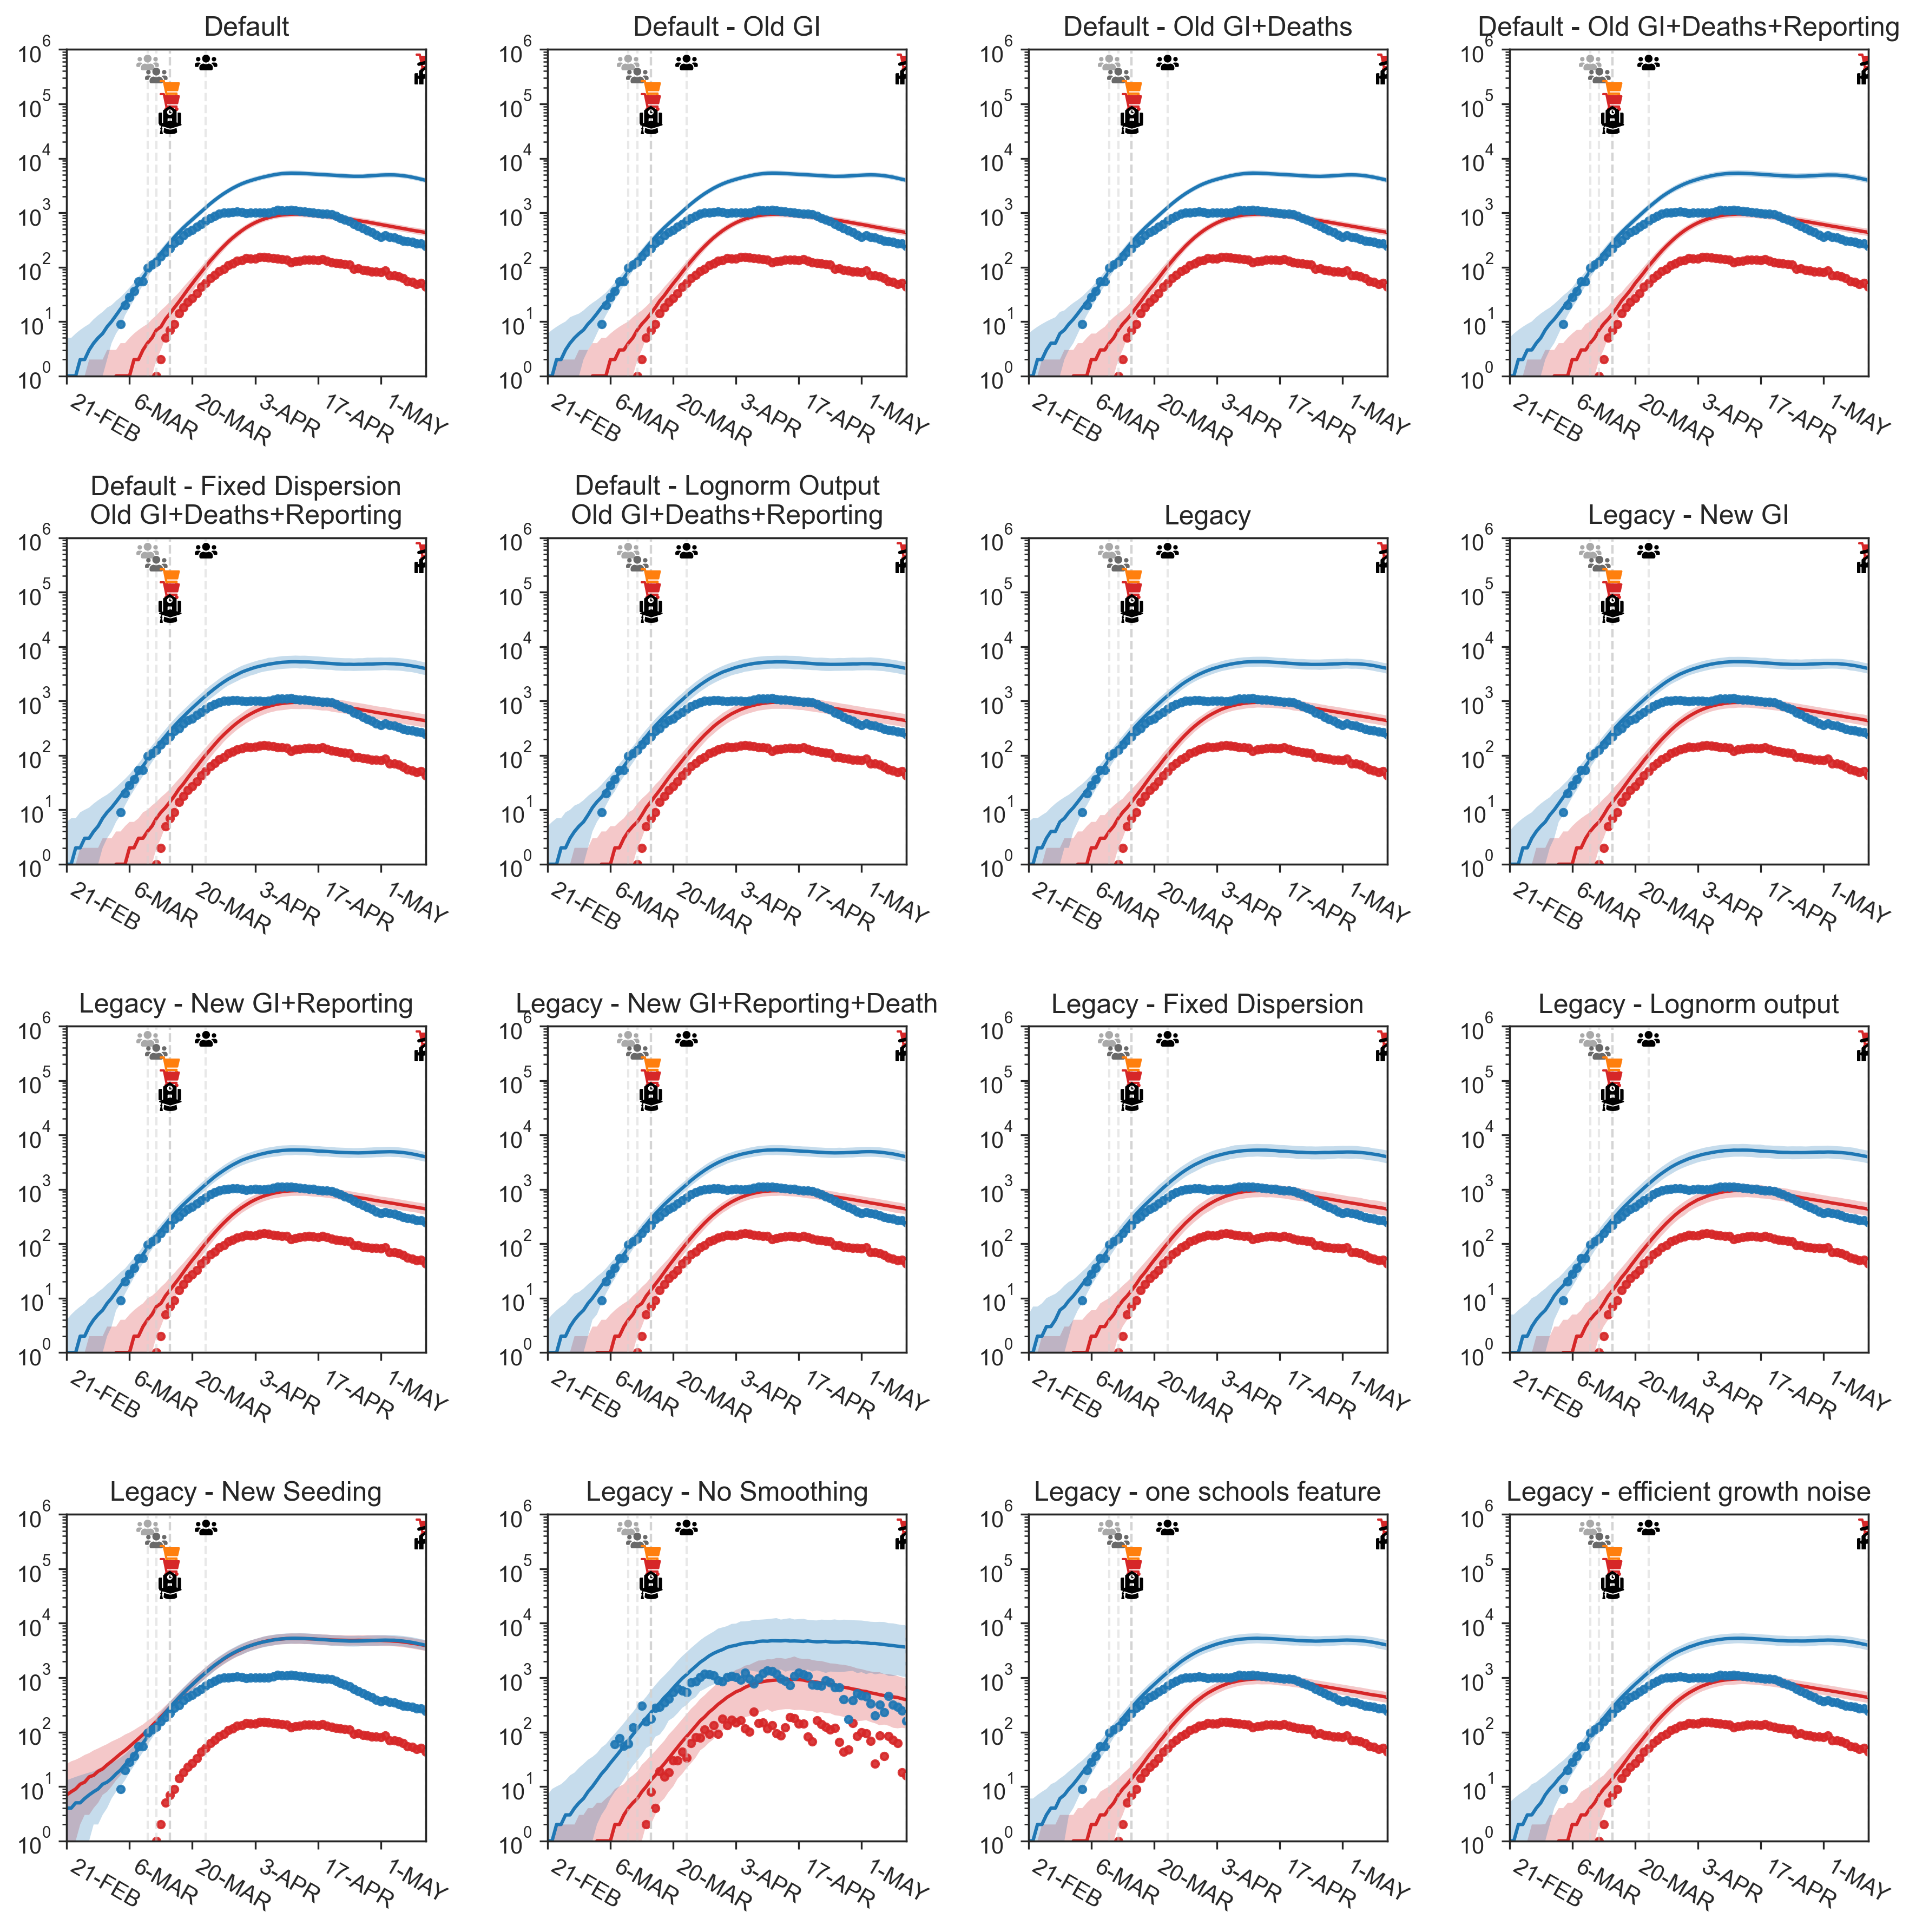

In [103]:
r_i = data.Rs.index('NL')

plt.figure(figsize=(12, 12), dpi=300)
for i, exp_i in enumerate(exps):
    plt.subplot(4, 4, i+1)
    ec, ed, alpha, name = load_rg_summary(exp_i, r_i)
    
    if 'No Smoothing' in name:
        data_in = data_ns
    else:
        data_in = data
    
    epicurve_plot(data_in, r_i, ec, ed, alpha)
    plt.title(name, fontsize=12)
plt.tight_layout()

**Note**: I spotted a bug in the 'New Seeding' version which meant it matched only to cases!

# Can we reparam?

In [104]:
path = f'../../server/bug_exps_new/bug_exps/exp_15.pkl'
trace = pickle.load(open(path, 'rb'))

In [110]:
trace.CMReduction[:, 7]

array([0.72280306, 0.85437198, 0.73808533, ..., 0.80295001, 0.73229473,
       0.63064857])

In [111]:
trace.CMReduction[:, 6]

array([0.73185399, 0.74812115, 0.72690649, ..., 0.70784876, 0.80049369,
       0.727785  ])

Text(0, 0.5, 'unis')

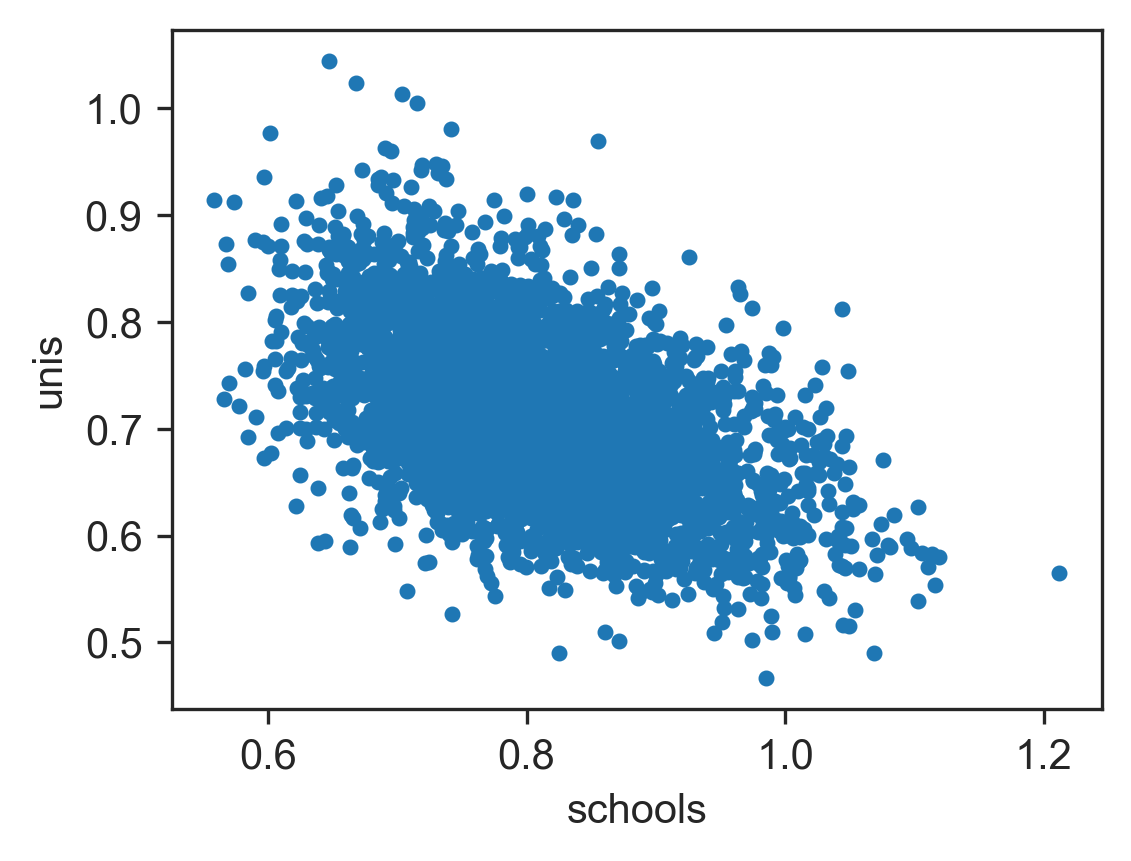

In [117]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(trace.CMReduction[:, 6], trace.CMReduction[:, 7], s=8)
plt.xlabel('schools')
plt.ylabel('unis')

Text(0, 0.5, 'schools + unis')

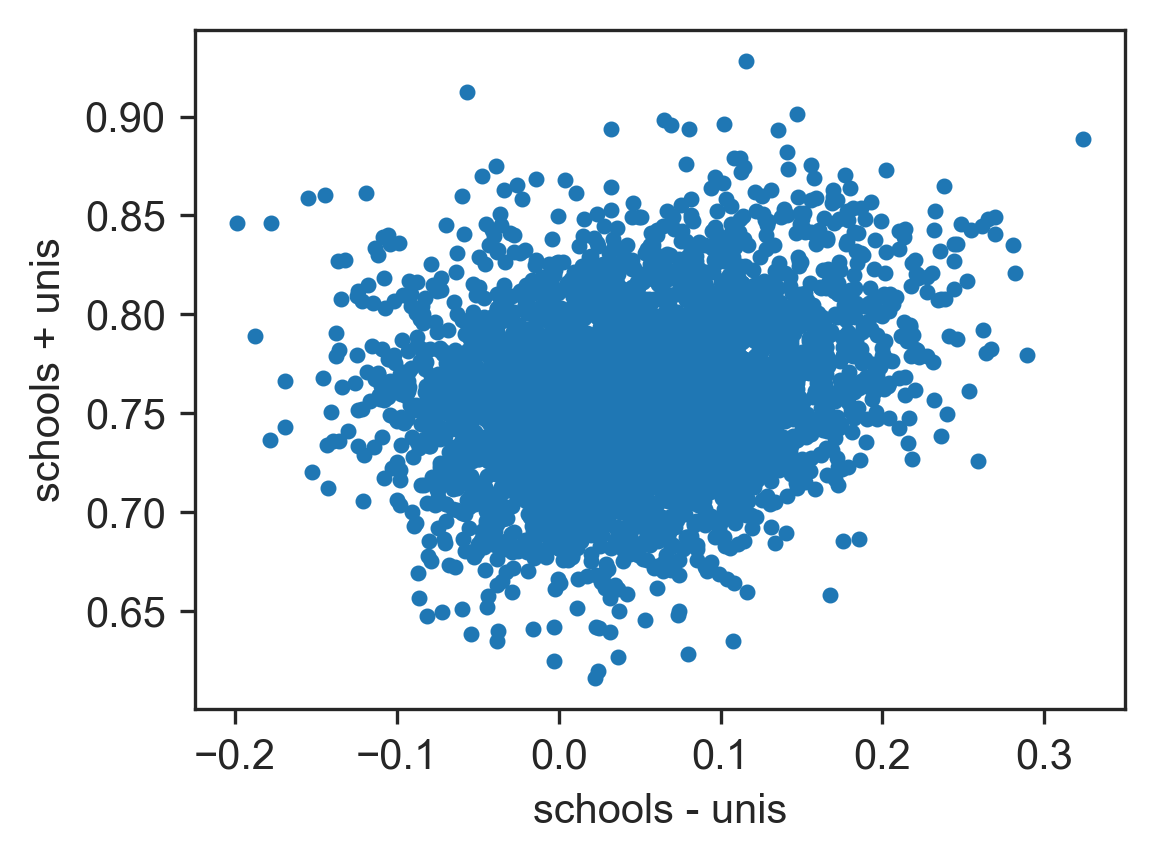

In [120]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(0.5*trace.CMReduction[:, 6]-0.5*trace.CMReduction[:, 7], 0.5*trace.CMReduction[:, 6]+0.5*trace.CMReduction[:, 7], s=8)
plt.xlabel('schools - unis')
plt.ylabel('schools + unis')

In [ ]:
plt.scatter(0.5*trace.CMReduction[:, 6]-0.5*trace.CMReduction[:, 7], 0.5*trace.CMReduction[:, 6]+0.5*trace.CMReduction[:, 7], s=8)